In [22]:

#utility imports
import time
import statistics
from team_pace import build_pace_dictionary
from team_pace import build_team_id_dictionary
from scraper import convert_gamelog_to_dataframe

#data sciencey imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#machine learning imports
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#nba_api imports
from nba_api.stats.static import players
from nba_api.stats.static import teams

#CONSTANTS
SEASON = '2019'
TEAM_LIST = teams.get_teams()


In [3]:
#build the pace dictionary - (takes a while)
team_pace_dict = build_pace_dictionary(SEASON)

#build the abbreviation and id dictionary
team_id_dict = build_team_id_dictionary(SEASON)

In [4]:
#find the team abbreviation given the team name
def add_abreviation(team_id):
    return [t["abbreviation"] for t in TEAM_LIST if t["id"] == team_id][0]

#build the season pace dictionary (index = team_id)
pace_df = pd.DataFrame.from_dict(team_pace_dict, "index")

pace_df.rename(columns={0:"pace"}, inplace=True)
pace_df["pace"] = pd.to_numeric(pace_df["pace"])
pace_df["abbv"] = pace_df.apply(lambda row: add_abreviation(row.name), axis=1)

pace_df.sort_values(by=["pace"], ascending=False, inplace=True)

#add the rank column (the method first assigns the higher rank to the first occurence of a duplicate value)
pace_df["rank"] = pace_df["pace"].rank(ascending=False, method="first")

In [5]:
#find some descriptive stats for the pace
pace_mean = pace_df["pace"].mean()
pace_std = pace_df["pace"].std()

print("Mean: ", round(pace_mean,2))
print(" Std: ", round(pace_std,2))
pace_df

Mean:  99.99
 Std:  2.17


,pace,abbv,rank
1610612737,103.9,ATL,1.0
1610612740,103.3,NOP,2.0
1610612749,103.3,MIL,3.0
1610612747,103.2,LAL,4.0
1610612758,103.1,SAC,5.0
1610612760,102.8,OKC,6.0
1610612746,101.7,LAC,7.0
1610612755,101.6,PHI,8.0
1610612764,101.4,WAS,9.0
1610612744,100.9,GSW,10.0


In [6]:
#classify the teams by pace
#label key
# 0 - slower - a team that is more than 1 std below the mean
# 1 - slow - a team that is less than 1 std below the mean
# 2 - fast - a team that is less than 1 std above the mean
# 3 - faster - a team that is more than 1 std above the mean
def label_team_pace(pace, pace_mean, pace_std):
    
    if(pace < pace_mean): 
        if(pace < pace_mean-pace_std): #a slower team
            label = 0
        else: # a slow team
            label = 1
    else:
        if(pace > pace_mean+pace_std): # a faster team
            label = 3
        else: # a fast team
            label = 2
    
    return label

#add the label to the team
pace_df["pace_label"] = pace_df.apply(lambda row: label_team_pace(row.pace, pace_mean, pace_std), axis=1)


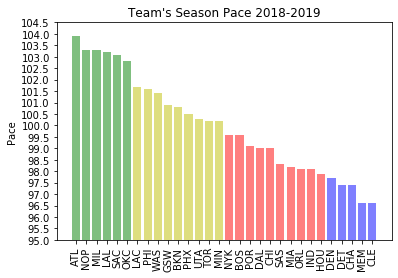

In [7]:
#a nice bar chart

def label_colors(label):
    if(label == 0):
        return 'b'
    elif(label == 1):
        return 'r'
    elif(label == 2):
        return 'y'
    else:
        return 'g'

#settings
y_offset = 95
y_min = 0
y_max = 10
y_step = 0.5

#create the x and y sets and labels
pace_y = pace_df["pace"].apply(lambda x: x - y_offset)
y_labels = np.arange(y_min+y_offset, y_max+y_offset, step=y_step)
x_labels = pace_df["abbv"]
pace_x = np.arange(len(x_labels))
color_labels = pace_df.apply(lambda row: label_colors(row.pace_label), axis=1)

#graph it
plt.bar(pace_x, pace_y, align="center", alpha=0.5, color=color_labels)
plt.xticks(pace_x, x_labels, rotation="vertical")
plt.yticks(np.arange(y_min, y_max, step=y_step), y_labels)
plt.ylabel("Pace")
plt.title("Team's Season Pace 2018-2019")
plt.show()

The bar graph shows a significant range in pace across teams in the NBA.  The Atlanata Hawks have the fastest pace of 103.9 possessions per game.  The Cleveland Cavaliers have the slowest pace with 96.6 possessions per game.  This gives a range of 7.3 possessions per game.  The average pace in the 2018-2019 season was 99.99 possessions/game with a standard deviation of 2.17 possessions/game.  ADD A LEGEND TO THE FIGURE TO EXPLAIN THE CLASSIFICATION AND COLOR OF EACH TEAM.  It's interesting to note the difference at the boundary of faster and fast teams.  The Thunder and Clippers have a difference of 1.1 possessions/game which is much larger than the boundary between the Rockets and Nuggets, which is 0.2 possessions.  There is a large differnce between the slowest two teams and the next highest.  The Grizzlies and Cavaliers both have a pace of 96.6, which is 0.8 possessions/game less than the next highest (Hornets - 97.4).  The higer differnece in a faster team's pace leads me to believe that a faster team will have a stronger effect on their opponents pace during a game.  The difference in pace will be measured by comparing the pace of the game to the teams season average.

In [8]:
#calculate the difference in a team's game pace from their season avg
# parameter - game_pace - the pace for the game
# parameter - team_abv - the team's abbreviation
# returns - the difference in pace
def calc_game_pace_difference(game_pace, team_abv):
    team_id = team_id_dict[team_abv]
    avg_pace = team_pace_dict[team_id]
    
    return float(game_pace) - float(avg_pace)

#calc the difference between the two teams season avg pace
# parameter - team_abv 
# parameter - opp_abv - the opponents abbreviation
# returns the difference in pace
def calc_team_pace_difference(team_abv, opp_abv):
    team_id = team_id_dict[team_abv]
    opp_id = team_id_dict[opp_abv]
    
    return float(team_pace_dict[team_id]) - float(team_pace_dict[opp_id])

In [9]:
#get a dataframe of the teams gamelog and the pace stat
TEAM_ABV = 'BOS'

team_df = convert_gamelog_to_dataframe(TEAM_ABV, SEASON)
team_df = team_df[["game_season","id","date_game","game_location","opp_id", "game_result", "pace"]]


In [10]:
#create the new columns
team_df["game_pace_diff"] = team_df.apply(lambda row: calc_game_pace_difference(row.pace, row.id), axis=1)
team_df["team_pace_diff"] = team_df.apply(lambda row: calc_team_pace_difference(row.id, row.opp_id), axis=1)

team_df.describe()
team_df

,game_season,id,date_game,game_location,opp_id,game_result,pace,game_pace_diff,team_pace_diff
0,1,BOS,2018-10-16,H,PHI,W,104.3,4.7,-2.0
1,2,BOS,2018-10-19,A,TOR,L,97.8,-1.8,-0.6
2,3,BOS,2018-10-20,A,NYK,W,99.3,-0.3,0.0
3,4,BOS,2018-10-22,H,ORL,L,96.4,-3.2,1.5
4,5,BOS,2018-10-25,A,OKC,W,100.0,0.4,-3.2
...,...,...,...,...,...,...,...,...,...
77,78,BOS,2019-04-01,H,MIA,W,98.4,-1.2,1.4
78,79,BOS,2019-04-03,A,MIA,W,97.8,-1.8,1.4
79,80,BOS,2019-04-05,A,IND,W,100.5,0.9,1.5
80,81,BOS,2019-04-07,H,ORL,L,99.9,0.3,1.5


In [11]:
season_df = ""
#calculate the TPD and GPD for each game in the season
for k,v in team_id_dict.items():
    #print(k)
    temp_df = convert_gamelog_to_dataframe(k, SEASON)
    temp_df = temp_df[["game_season","id","date_game","game_location","opp_id", "game_result", "pace"]]
    
    temp_df["game_pace_diff"] = temp_df.apply(lambda row: calc_game_pace_difference(row.pace, row.id), axis=1)
    temp_df["team_pace_diff"] = temp_df.apply(lambda row: calc_team_pace_difference(row.id, row.opp_id), axis=1)
    
    if(season_df is ""):
        season_df = temp_df
    else:
        season_df = season_df.append(temp_df)

In [12]:
#add the pace labels to the gamelog season dataframe
def find_pace_label(team_abv):
    if(team_abv == "BRK"):
        team_abv = "BKN"
    elif(team_abv == "CHO"):
        team_abv = "CHA"
    elif(team_abv == "PHO"):
        team_abv = "PHX"
    else:
        pass
        
    row = pace_df.loc[pace_df["abbv"] == team_abv]
    
    #print(team_abv, row["pace_label"].values)
    
    return row.pace_label.values[0]

season_df["pace_label"] = season_df.apply(lambda row: find_pace_label(row["id"]), axis=1)
season_df["opp_pace_label"] = season_df.apply(lambda row: find_pace_label(row["opp_id"]), axis=1)
    
    
    

In [50]:
#group the teams
faster_teams_df = season_df.loc[season_df["pace_label"] == 3]
fast_teams_df = season_df.loc[season_df["pace_label"] == 2]
slow_teams_df = season_df.loc[season_df["pace_label"] == 1]
slower_teams_df = season_df.loc[season_df["pace_label"] == 0]

pace_groups = [faster_teams_df,fast_teams_df,slow_teams_df,slower_teams_df]
pace_names = ["Faster", "Fast", "Slow", "Slower"]

pace_diff_df = pd.DataFrame(columns=["Faster","Fast","Slow","Slower"])

#group the opponents for each group and find average GPD and jam into a dataframe
for group, name in zip(pace_groups, pace_names):
    means = group.groupby(group["opp_pace_label"]).mean()["game_pace_diff"]
    pace_diff_df = pace_diff_df.append(pd.Series({ "Faster": means[0],
                                                   "Fast": means[2],
                                                   "Slow": means[1],
                                                   "Slower":means[3]}, name=name))
#add the axis labels to this 
pace_diff_df

,Faster,Fast,Slow,Slower
Faster,-3.365854,-0.039744,-1.872024,3.941860
Fast,-2.999219,0.383838,-1.800391,2.390385
Slow,-3.206164,0.356641,-2.120800,2.742857
Slower,-4.338889,0.717187,-1.656164,2.767073


In [14]:
#apply the color to each cell in the frame
def cell_color(value):
    c = ""
    if(value >= 0):
        c = '#6dd672'
    else:
        c = '#ff6666'
    
    return 'background-color: %s' % c

pace_diff_df.style.applymap(cell_color)

,Faster,Fast,Slow,Slower
Faster,3.94186,-0.0397436,-1.87202,-3.36585
Fast,2.39038,0.383838,-1.80039,-2.99922
Slow,2.74286,0.356641,-2.1208,-3.20616
Slower,2.76707,0.717187,-1.65616,-4.33889


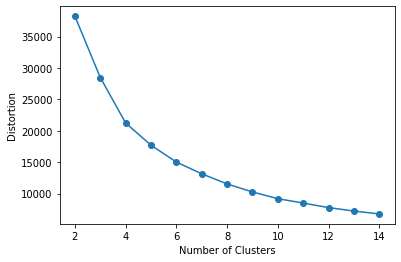

In [15]:
#gunna try to do some clustering here for later articles
#y = season_df["team_pace_diff"].values.reshape(-1,1)
X = season_df[["game_pace_diff","team_pace_diff"]]      #["game_pace_diff"].values.reshape(-1,1)

distortions = []

distortions = []
for i in range(2, 15):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(2,15), distortions, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel('Distortion')
plt.show()

0.1184148167699478


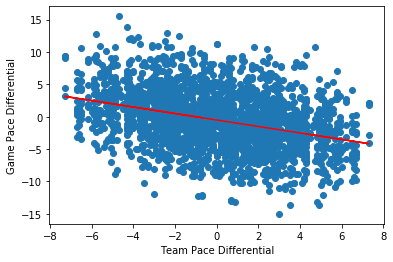

In [49]:
# make the clusters based off the number of clusters above
num_clusters = 4

#set x and y
y = season_df[["game_pace_diff"]]
x = season_df[["team_pace_diff"]]

#make the Kmeans model and fit the data
k_model = KMeans(n_clusters=num_clusters, random_state=0)
y_model = k_model.fit_predict(X)

season_df["cluster_label"] = y_model

#make the linear regression model and fit the data
lr_model = LinearRegression().fit(x,y)
lr_predict = lr_model.predict(x)

season_df.groupby(by="cluster_label").describe() #find the number in each group

plt.xlabel('Team Pace Differential')
plt.ylabel('Game Pace Differential')

#plt.scatter(x, y, c=season_df["cluster_label"], cmap='Dark2')
plt.scatter(x, y)
plt.plot(x, lr_predict, color='red')

plt.axis(option='on')

print(lr_model.score(x,y))

In [40]:

season_df[["game_pace_diff", "team_pace_diff"]].corr()

,game_pace_diff,team_pace_diff
game_pace_diff,1.000000,-0.344115
team_pace_diff,-0.344115,1.000000
